In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/sample_data.csv')



In [3]:
features = ['calories', 'protein', 'carbs', 'fat', 'activity_minutes', 'steps', 'sleep_hours']

# Create rolling features
for col in features:
    df[f'{col}_roll_7'] = df[col].rolling(7).mean()

df['weight_roll_7'] = df['weight'].rolling(7).mean()

df = df.dropna(subset=[f'{col}_roll_7' for col in features] + ['weight_roll_7'])

roll_features = [f'{col}_roll_7' for col in features]

X = df[roll_features]
y = df['weight_roll_7']


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

xg_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xg_model.fit(X_train, y_train)

y_pred = xg_model.predict(X_test)

print("XGBoost R² Score:", r2_score(y_test, y_pred))
print("XGBOOST MSE:", mean_squared_error(y_test, y_pred))


XGBoost R² Score: 0.8589230757217687
XGBOOST MSE: 0.058650310189733615


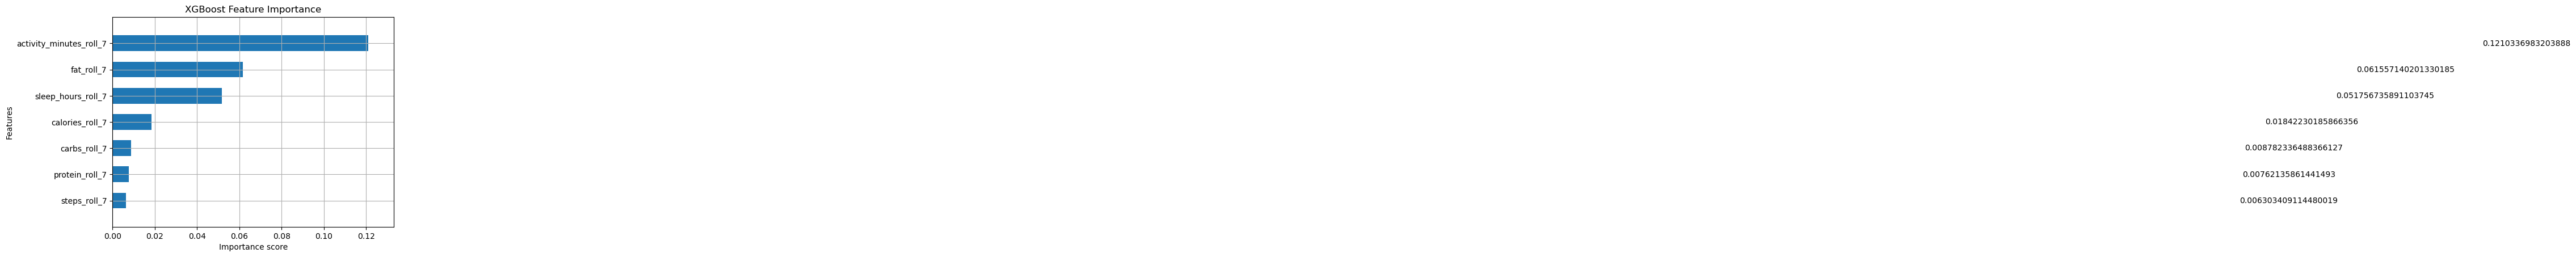

In [13]:
xgb.plot_importance(xg_model, height=0.6, importance_type='gain')
plt.title("XGBoost Feature Importance")
plt.show()


In [23]:
import joblib
joblib.dump(xg_model, "xgb_weight_model.pkl")


['xgb_weight_model.pkl']

SQLite Integration

In [15]:
df['predicted_weight_roll_7'] = xg_model.predict(X)


In [16]:
roll_features = [f"{col}_roll_7" for col in ['calories', 'protein', 'carbs', 'fat', 'activity_minutes', 'steps', 'sleep_hours']]

df_export = df[['date', 'weight', 'weight_roll_7', 'predicted_weight_roll_7'] + roll_features].copy()


In [19]:
df = df.reset_index()  # assumes your index is datetime or sequential
df.rename(columns={'index': 'date'}, inplace=True)


In [20]:
df_export['error'] = df_export['weight_roll_7'] - df_export['predicted_weight_roll_7']


In [21]:
import sqlite3

conn = sqlite3.connect('metabolism_tracker.db')
df_export.to_sql('metabolism_data', conn, if_exists='replace', index=False)
conn.close()
